<a href="https://colab.research.google.com/github/hilaliya/SLAM/blob/main/GRAPH_SLAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# import some resources
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [6]:
# the robot class
class robot:

    # --------
    # init: 
    #   creates a robot with the specified parameters and initializes 
    #   the location (self.x, self.y) to the center of the world
    #
    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        self.measurement_noise = 0.0
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0


    # returns a positive, random float
    def rand(self):
        return random.random() * 2.0 - 1.0


    # --------
    # move: attempts to move robot by dx, dy. If outside world
    #       boundary, then the move does nothing and instead returns failure
    #
    def move(self, dx, dy):

        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True
    

    # --------
    # sense: returns x- and y- distances to landmarks within visibility range
    #        because not all landmarks may be in this range, the list of measurements
    #        is of variable length. Set measurement_range to -1 if you want all
    #        landmarks to be visible at all times
    #
    
    ## TODO: complete the sense function
    def sense(self):
        ''' This function does not take in any parameters, instead it references internal variables
            (such as self.landmarks) to measure the distance between the robot and any landmarks
            that the robot can see (that are within its measurement range).
            This function returns a list of landmark indices, and the measured distances (dx, dy)
            between the robot's position and said landmarks.
            This function should account for measurement_noise and measurement_range.
            One item in the returned list should be in the form: [landmark_index, dx, dy].
            '''
           
        measurements = []
        
        ## TODO: iterate through all of the landmarks in a world
        
        ## TODO: For each landmark
        ## 1. compute dx and dy, the distances between the robot and the landmark
        ## 2. account for measurement noise by *adding* a noise component to dx and dy
        ##    - The noise component should be a random value between [-1.0, 1.0)*measurement_noise
        ##    - Feel free to use the function self.rand() to help calculate this noise component
        ##    - It may help to reference the `move` function for noise calculation
        ## 3. If either of the distances, dx or dy, fall outside of the internal var, measurement_range
        ##    then we cannot record them; if they do fall in the range, then add them to the measurements list
        ##    as list.append([index, dx, dy]), this format is important for data creation done later
        
        for index, landmark in enumerate(self.landmarks):
            # dx and dy computed
            dx = landmark[0] - self.x
            dy = landmark[1] - self.y

            # adding noise
            noise = self.rand() * self.measurement_noise
            dx += noise
            dy += noise

            # check if out of range
            if(abs(dx) < self.measurement_range and abs(dy) < self.measurement_range):
                measurements.append([index, dx, dy])

        ## TODO: return the final, complete list of measurements
        return measurements

    
    # --------
    # make_landmarks: 
    # make random landmarks located in the world
    #
    def make_landmarks(self, num_landmarks):
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
        self.num_landmarks = num_landmarks
    
    
    # called when print(robot) is called; prints the robot's location
    def __repr__(self):
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)

In [8]:
from math import *
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# --------
# this helper function displays the world that a robot is in
# it assumes the world is a square grid of some given size
# and that landmarks is a list of landmark positions(an optional argument)
def display_world(world_size, position, landmarks=None):
    
    # using seaborn, set background grid to gray
    sns.set_style("dark")

    # Plot grid of values
    world_grid = np.zeros((world_size+1, world_size+1))

    # Set minor axes in between the labels
    ax=plt.gca()
    cols = world_size+1
    rows = world_size+1

    ax.set_xticks([x for x in range(1,cols)],minor=True )
    ax.set_yticks([y for y in range(1,rows)],minor=True)
    
    # Plot grid on minor axes in gray (width = 1)
    plt.grid(which='minor',ls='-',lw=1, color='white')
    
    # Plot grid on major axes in larger width
    plt.grid(which='major',ls='-',lw=2, color='white')
    
    # Create an 'o' character that represents the robot
    # ha = horizontal alignment, va = vertical
    ax.text(position[0], position[1], 'o', ha='center', va='center', color='r', fontsize=30)
    
    # Draw landmarks if they exists
    if(landmarks is not None):
        # loop through all path indices and draw a dot (unless it's at the car's location)
        i=0
        for pos in landmarks:
            if(pos != position):
                ax.text(pos[0], pos[1], 'x', ha='center', va='center', color='purple', fontsize=20)
                ax.text(pos[0], pos[1]-0.5, i, ha='center', va='center', color='purple', fontsize=8)
                i+=1
    
    # Display final result
    plt.show()

    
# --------
# this routine makes the robot data
# the data is a list of measurements and movements: [measurements, [dx, dy]]
# collected over a specified number of time steps, N
#
def make_data(N, num_landmarks, world_size, measurement_range, motion_noise, 
              measurement_noise, distance):

    # check that data has been made
    try:
        check_for_data(num_landmarks, world_size, measurement_range, motion_noise, measurement_noise)
    except ValueError:
        print('Error: You must implement the sense function in robot_class.py.')
        return []
    
    complete = False
    
    r = robot(world_size, measurement_range, motion_noise, measurement_noise)
    r.make_landmarks(num_landmarks)

    while not complete:

        data = []

        seen = [False for row in range(num_landmarks)]
    
        # guess an initial motion
        orientation = random.random() * 2.0 * pi
        dx = cos(orientation) * distance
        dy = sin(orientation) * distance
            
        for k in range(N-1):
    
            # collect sensor measurements in a list, Z
            Z = r.sense()

            # check off all landmarks that were observed 
            for i in range(len(Z)):
                seen[Z[i][0]] = True
    
            # move
            while not r.move(dx, dy):
                # if we'd be leaving the robot world, pick instead a new direction
                orientation = random.random() * 2.0 * pi
                dx = cos(orientation) * distance
                dy = sin(orientation) * distance

            # collect/memorize all sensor and motion data
            data.append([Z, [dx, dy]])

        # we are done when all landmarks were observed; otherwise re-run
        complete = (sum(seen) == num_landmarks)

    print(' ')
    print('Landmarks: ', r.landmarks)
    print(r)


    return data

Robot: [x=5.00000 y=5.00000]


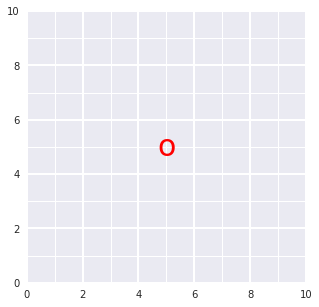

In [42]:
# import helper function
world_size         = 10.0    # size of world (square)
measurement_range  = 5.0     # range at which we can sense landmarks
motion_noise       = 0.2      # noise in robot motion
measurement_noise  = 0.2      # noise in the measurements

# instantiate a robot, r
r = robot(world_size, measurement_range, motion_noise, measurement_noise)
# define figure size
plt.rcParams["figure.figsize"] = (5,5)

# call display_world and display the robot in it's grid world
print(r)
display_world(int(world_size), [r.x, r.y])

Robot: [x=5.00000 y=5.00000]


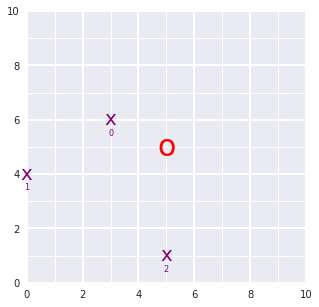

Landmark locations [x,y]:  [[3, 6], [0, 4], [5, 1]]


In [45]:
# create any number of landmarks
num_landmarks = 3
r.make_landmarks(num_landmarks)

# print out our robot's exact location
print(r)

# display the world including these landmarks
display_world(int(world_size), [r.x, r.y], r.landmarks)

# print the locations of the landmarks
print('Landmark locations [x,y]: ', r.landmarks)

In [46]:
# try to sense any surrounding landmarks
measurements = r.sense()

# this will print out an empty list if `sense` has not been implemented
print(measurements)

data = []

[[0, -2.168606226873165, 0.8313937731268346], [1, -4.964235207854006, -0.9642352078540065], [2, 0.15023475535596945, -3.8497652446440305]]


Robot: [x=5.00000 y=5.00000]


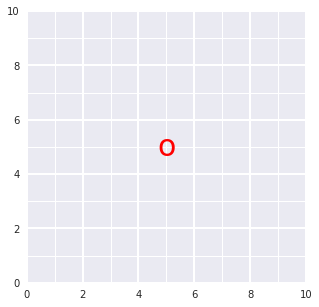

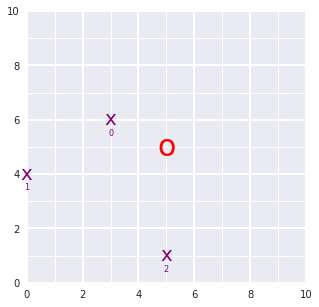

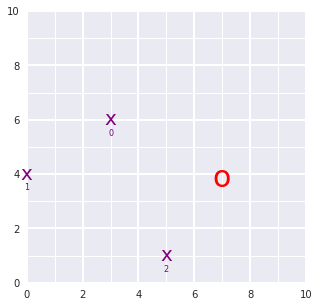

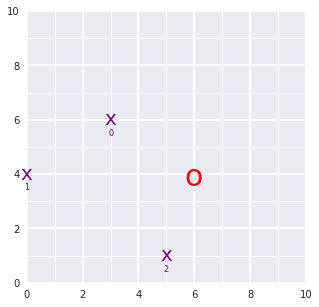

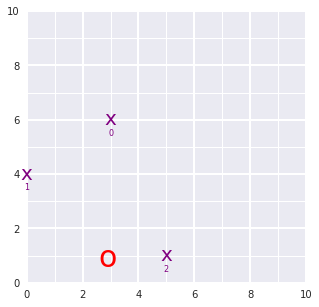

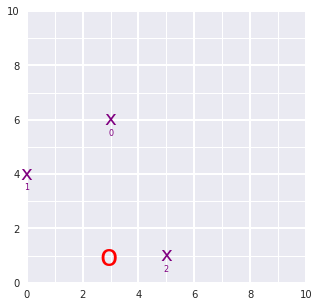

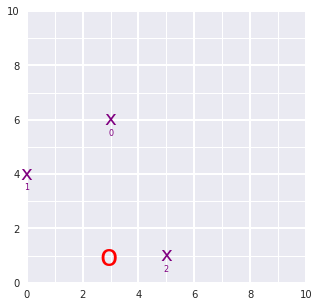

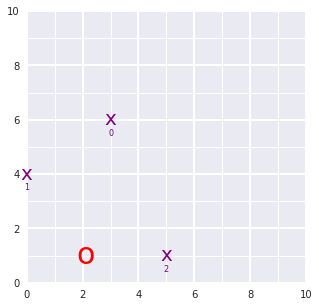

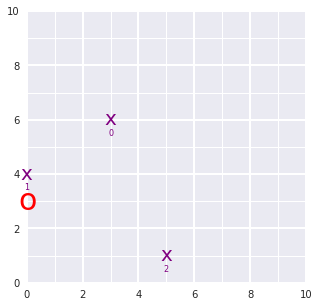

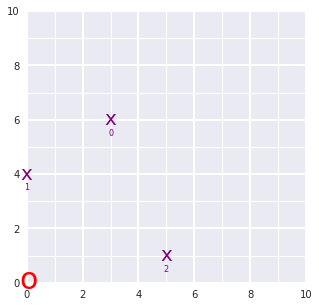

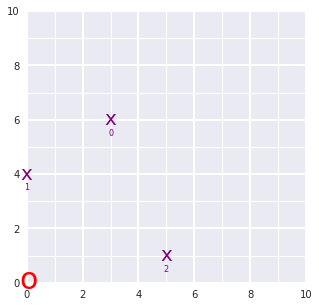

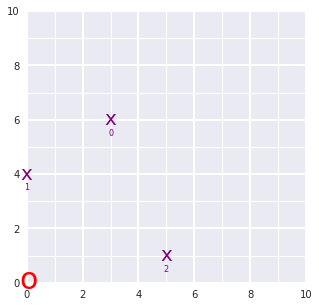

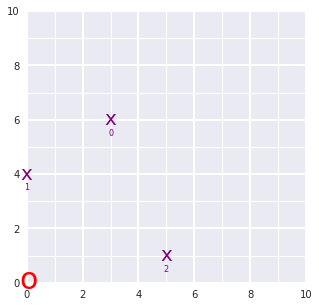

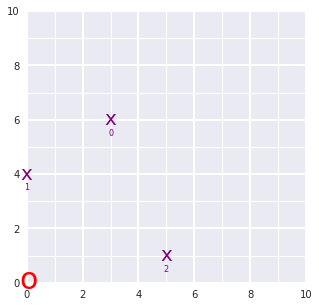

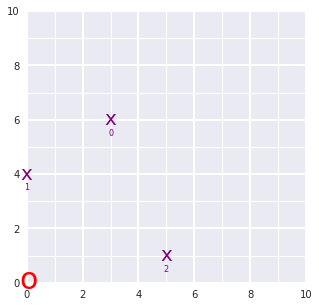

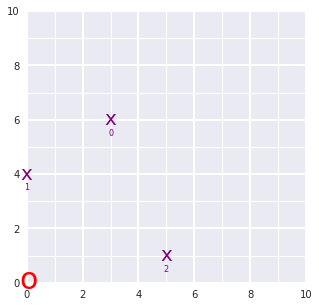

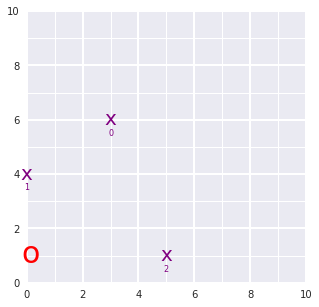

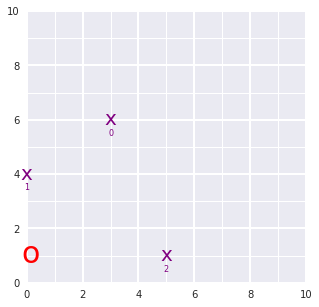

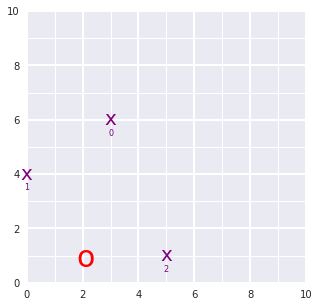

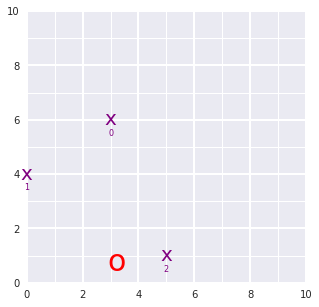

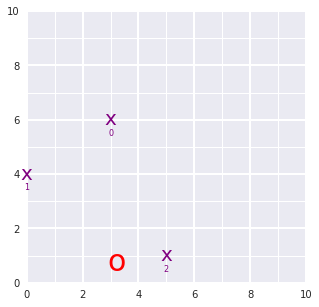

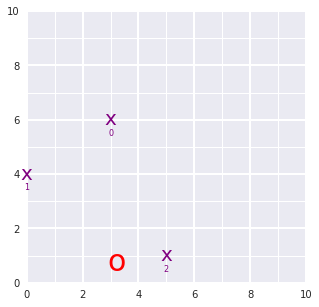

[[[[0, -4.133033755479313, 2.008873707512018], [2, -2.061906061476111, -2.9199985984847796]], [2, -1]], [[[0, -3.0207294897735255, 2.0836625501090493], [2, -1.0766755378421378, -2.972283497959563]], [-1, 0]], [[[1, -2.9519246056476036, 3.023477014434654], [2, 1.9571650921277064, -0.06743328779003602]], [-3, -3]], [[[1, -3.112503372528437, 2.861762565283816], [2, 2.1392918127901823, 0.1135577506024347]], [0, 0]], [[[1, -2.904900320448492, 3.069365617363761], [2, 1.9817076077729179, -0.04402645441482966]], [1, -1]], [[[0, 0.8521439807288729, 4.950767814239559], [1, -2.133442475145365, 2.9651813583653217], [2, 2.8188163471309764, -0.08255981935833696]], [-1, 0]], [[[0, 3.1852251576192963, 3.2011659529171395], [1, -0.15133166985563187, 0.8646091254422112]], [-2, 2]], [[[1, -0.23529983989439435, 3.7525685470790426]], [0, -3]], [[[1, -0.22880862091585252, 3.7590597660575846]], [3, -3]], [[[1, 0.07183285861541179, 4.059701245588849]], [3, 0]], [[[1, -0.11077838131847066, 3.877090005654966], [

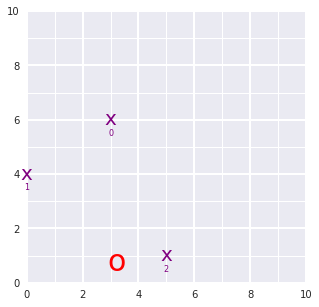

Landmark locations [x,y]:  [[3, 6], [0, 4], [5, 1]]


In [47]:
print(r)
display_world(int(world_size), [r.x, r.y])
display_world(int(world_size), [r.x, r.y], r.landmarks)
data = []

N=20
for i in range(N):
  dx=random.randint(-3,3)
  dy=random.randint(-3,3)
  r.move(dx, dy)
  measurements = r.sense()
  data.append([measurements, [dx,dy]])
  display_world(int(world_size), [r.x, r.y], r.landmarks)

# for our example movement and measurement
print(data)

# print the locations of the landmarks
print('Landmark locations [x,y]: ', r.landmarks)

In [48]:
# in this example, we have only created one time step (0)
for time_step in range(N):

# so you can access robot measurements:
  print(time_step , data[time_step][0])

0 [[0, -4.133033755479313, 2.008873707512018], [2, -2.061906061476111, -2.9199985984847796]]
1 [[0, -3.0207294897735255, 2.0836625501090493], [2, -1.0766755378421378, -2.972283497959563]]
2 [[1, -2.9519246056476036, 3.023477014434654], [2, 1.9571650921277064, -0.06743328779003602]]
3 [[1, -3.112503372528437, 2.861762565283816], [2, 2.1392918127901823, 0.1135577506024347]]
4 [[1, -2.904900320448492, 3.069365617363761], [2, 1.9817076077729179, -0.04402645441482966]]
5 [[0, 0.8521439807288729, 4.950767814239559], [1, -2.133442475145365, 2.9651813583653217], [2, 2.8188163471309764, -0.08255981935833696]]
6 [[0, 3.1852251576192963, 3.2011659529171395], [1, -0.15133166985563187, 0.8646091254422112]]
7 [[1, -0.23529983989439435, 3.7525685470790426]]
8 [[1, -0.22880862091585252, 3.7590597660575846]]
9 [[1, 0.07183285861541179, 4.059701245588849]]
10 [[1, -0.11077838131847066, 3.877090005654966], [2, 4.8869127106424575, 0.8747810976158945]]
11 [[1, -0.19444122743574926, 3.793427159537688], [2, 

In [49]:
def initialize_constraints(N, num_landmarks, world_size):
    ''' This function takes in a number of time steps N, number of landmarks, and a world_size,
        and returns initialized constraint matrices, omega and xi.'''
    
    ## Recommended: Define and store the size (rows/cols) of the constraint matrix in a variable
    size = (N + num_landmarks)*2
    rows = size
    cols = size

    ## TODO: Define the constraint matrix, Omega, with two initial "strength" values
    ## for the initial x, y location of our robot
    omega = np.zeros((rows,cols))
    
    strength = 1
    
    mid = world_size / 2
    initial_x = mid
    initial_y = mid
    
    omega[0,0] = strength
    omega[1,1] = strength
    ## TODO: Define the constraint *vector*, xi
    ## you can assume that the robot starts out in the middle of the world with 100% confidence
    xi = np.zeros((rows, 1))
    xi[0] = initial_x
    xi[1] = initial_y
    return omega, xi

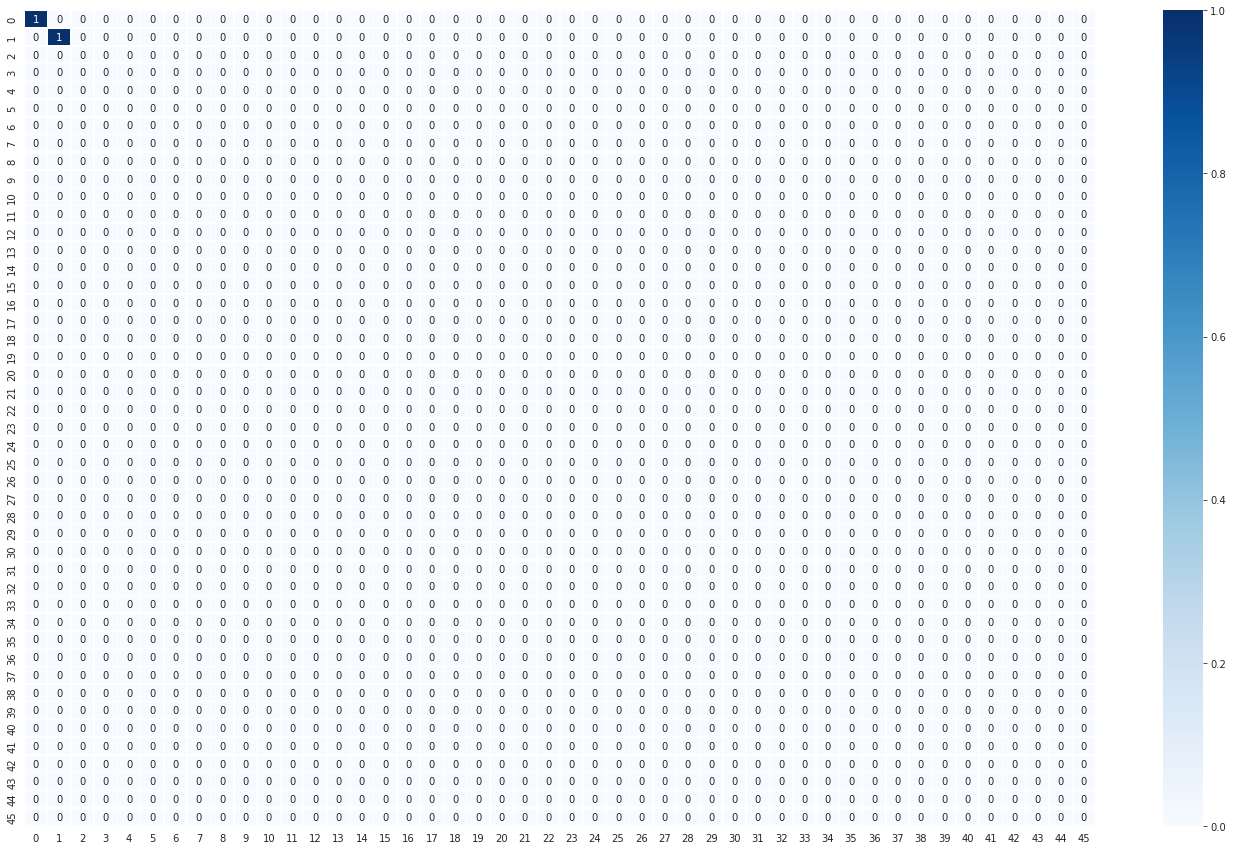

In [54]:
# import data viz resources
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

# initialize the constraints
initial_omega, initial_xi = initialize_constraints(N, num_landmarks, world_size)

# define figure size
plt.rcParams["figure.figsize"] = (24,15)

# display omega
sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)

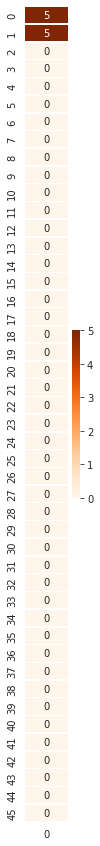

In [56]:
# define  figure size
plt.rcParams["figure.figsize"] = (1,15)

# display xi
sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)

In [63]:
1/measurement_noise

5.0

In [65]:
## slam takes in 6 arguments and returns mu, 
## mu is the entire path traversed by a robot (all x,y poses) *and* all landmarks locations
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    
    ## TODO: Use your initilization to create constraint matrices, omega and xi
    omega, xi = initialize_constraints(N, num_landmarks, world_size)
    
    ## TODO: Iterate through each time step in the data
    ## get all the motion and measurement data as you iterate
    for i in range(len(data)):
        measurements = data[i][0]
        motion = data[i][1]
        dx = motion[0]

        ## TODO: update the constraint matrix/vector to account for all *measurements*
        ## this should be a series of additions that take into account the measurement noise
        nweight = 1 / measurement_noise
        for m in measurements:
            print("m:", m)
            landmark = m[0]
            x = m[1]
            y=  m[2]
            
            omega[2*i, 2*i] += nweight
            omega[2*i, 2*N + 2*landmark] += -nweight
            omega[2*N + 2*landmark, 2*i] += -nweight
            omega[2*N + 2*landmark, 2*N + 2*landmark] += nweight 

            xi[2*i, 0] += -x *nweight
            xi[2*N + 2*landmark, 0] += x *nweight
            
            omega[2*i + 1, 2*i + 1] += nweight
            omega[2*i + 1, 2*N + 2*landmark + 1] += -nweight
            omega[2*N + 2*landmark + 1, 2*i + 1] += -nweight
            omega[2*N + 2*landmark + 1, 2*N + 2*landmark + 1] += nweight
            xi[2*i + 1, 0] += -y *nweight
            xi[2*N + 2*landmark + 1, 0] += y *nweight  
            
     ## TODO: update the constraint matrix/vector to account for all *motion* and motion noise       
        dx = motion[0]             
        dy = motion[1]
        mweight = 1 / motion_noise
    
        omega[2*i, 2*i] +=  mweight
        omega[2*i, 2*i + 2] += - mweight
        omega[2*i + 2, 2*i] += - mweight
        omega[2*i + 2, 2*i + 2] += mweight
        
        xi[2*i, 0] += -dx  * mweight             
        xi[2*i + 2, 0] += dx * mweight   
        
  
        omega[2*i + 1, 2*i + 1] += mweight
        omega[2*i + 1, 2*i + 3] += - mweight
        omega[2*i + 3, 2*i + 1] += - mweight
        omega[2*i + 3, 2*i + 3] += mweight 
        
        xi[2*i + 1, 0] += -dy * mweight
        xi[2*i + 3, 0] += dy * mweight
        
    ## TODO: After iterating through all the data
    ## Compute the best estimate of poses and landmark positions
    ## using the formula, omega_inverse * Xi
    mu = np.linalg.inv(np.matrix(omega)) * xi
    return mu # return `mu`

In [29]:
# a helper function that creates a list of poses and of landmarks for ease of printing
# this only works for the suggested constraint architecture of interlaced x,y poses
def get_poses_landmarks(mu, N):
    # create a list of poses
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    # create a list of landmarks
    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    # return completed lists
    return poses, landmarks

In [30]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')

In [66]:
# call your implementation of slam, passing in the necessary parameters

initial_omega, initial_xi = initialize_constraints(N, num_landmarks, world_size)
mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

# print out the resulting landmarks and poses
if(mu is not None):
    # get the lists of poses and landmarks
    # and print them out
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)

m: [0, -4.133033755479313, 2.008873707512018]
m: [2, -2.061906061476111, -2.9199985984847796]
m: [0, -3.0207294897735255, 2.0836625501090493]
m: [2, -1.0766755378421378, -2.972283497959563]
m: [1, -2.9519246056476036, 3.023477014434654]
m: [2, 1.9571650921277064, -0.06743328779003602]
m: [1, -3.112503372528437, 2.861762565283816]
m: [2, 2.1392918127901823, 0.1135577506024347]
m: [1, -2.904900320448492, 3.069365617363761]
m: [2, 1.9817076077729179, -0.04402645441482966]
m: [0, 0.8521439807288729, 4.950767814239559]
m: [1, -2.133442475145365, 2.9651813583653217]
m: [2, 2.8188163471309764, -0.08255981935833696]
m: [0, 3.1852251576192963, 3.2011659529171395]
m: [1, -0.15133166985563187, 0.8646091254422112]
m: [1, -0.23529983989439435, 3.7525685470790426]
m: [1, -0.22880862091585252, 3.7590597660575846]
m: [1, 0.07183285861541179, 4.059701245588849]
m: [1, -0.11077838131847066, 3.877090005654966]
m: [2, 4.8869127106424575, 0.8747810976158945]
m: [1, -0.19444122743574926, 3.793427159537688]


Last pose:  (1.855752529188976, 4.109096968400802)


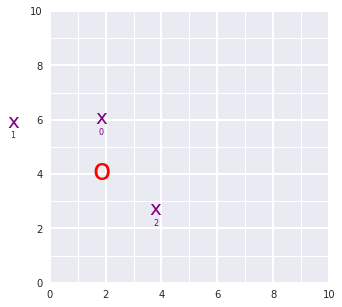

In [67]:
# define figure size
plt.rcParams["figure.figsize"] = (5,5)

# check if poses has been created
if 'poses' in locals():
    # print out the last pose
    print('Last pose: ', poses[-1])
    # display the last position of the robot *and* the landmark positions
    display_world(int(world_size), poses[-1], landmarks)